##### Download libraries 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
from pandas_datareader import data as pdr
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from google.colab import files

##### Download data 

In [2]:
yf.pdr_override()

ETFs = ['SIZE', 'VTV', 'MTUM', 'XDND.DE', 'IWQU.L', 'USMV', 'VUG']
ETFs_names = ['Size', 'Value', 'Momentum', 'High dividend', 'Quality', 'Min volatility', 'Growth']

start_date = "2015-01-01"
end_date = "2023-04-01"

ETF_prices_1 = pdr.get_data_yahoo(ETFs[4], start=start_date, end=end_date)[['Adj Close']] # Quality
ETF_prices_2 = pdr.get_data_yahoo(ETFs[:3] + ETFs[5:], start=start_date, end=end_date)[['Adj Close']]
ETF_prices_3 = pdr.get_data_yahoo(ETFs[3], start=start_date, end=end_date)[['Adj Close']] # High dividend

# Remove time and keep date
ETF_prices_1.index = pd.to_datetime(ETF_prices_1.index).date
ETF_prices_2.index = pd.to_datetime(ETF_prices_2.index).date
ETF_prices_3.index = pd.to_datetime(ETF_prices_3.index).date

# Change column names with factors
ETF_prices_1.rename(columns = {'Adj Close': ETFs_names[4]}, inplace = True)
ETF_prices_2.columns = ETF_prices_2.columns.droplevel(0)
ETF_prices_2.rename(columns = {ETFs[0]: ETFs_names[0], ETFs[1]: ETFs_names[1], ETFs[2]: ETFs_names[2], ETFs[5]: ETFs_names[5], ETFs[6]: ETFs_names[6]}, inplace = True)
ETF_prices_3.rename(columns = {'Adj Close': ETFs_names[3]}, inplace = True)

ETF_prices_all = ETF_prices_1.join(ETF_prices_2.join(ETF_prices_3))
ETF_prices_all = ETF_prices_all[ETFs_names]

ETF_prices_all.interpolate(limit_direction='both', inplace=True)
T, N = ETF_prices_all.shape

ETF_prices_all.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-2-638c37e5d264>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETF_prices_3.rename(columns = {'Adj Close': ETFs_names[3]}, inplace = True)


,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
2015-01-02,56.871387,68.215607,61.180923,20.719999,25.575001,34.630634,95.854546
2015-01-05,56.183552,66.956390,60.388596,20.590000,25.155001,34.305790,94.181114
2015-01-06,55.957195,66.367119,59.875370,20.480000,24.995001,34.211750,93.289238
2015-01-07,56.470886,67.109749,60.865799,20.730000,25.045000,34.647736,94.456963
2015-01-08,57.315426,68.344734,62.108311,21.180000,25.615000,35.160656,96.121201


In [3]:
# Get S&P 500 prices
SP500_prices = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)[['Adj Close']]
SP500_prices.index = pd.to_datetime(SP500_prices.index).date
SP500_prices.rename(columns = {'Adj Close': 'S&P 500'}, inplace = True)
SP500_prices.interpolate(limit_direction='both', inplace=True)

# Compute log returns
SP500_log_ret = (SP500_prices.pct_change() + 1).apply(np.log)
SP500_log_ret = SP500_log_ret.tail(-1)

# Get the performance of S&P for a given period
def getSP500_perf(start_from=None):
    SP500_perf = 1 + np.cumsum(SP500_log_ret.iloc[start_from:,])
    return SP500_perf

[*********************100%***********************]  1 of 1 completed


<ipython-input-3-855e1060d37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SP500_prices.rename(columns = {'Adj Close': 'S&P 500'}, inplace = True)
<ipython-input-3-855e1060d37e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SP500_prices.interpolate(limit_direction='both', inplace=True)


The next step is to calculate log returns 

In [4]:
# Compute log returns
ETF_log_ret_all = (ETF_prices_all.pct_change() + 1).apply(np.log)

# Remove the first line
ETF_log_ret_all = ETF_log_ret_all.tail(-1)

# Convert to numpy array
ETF_log_ret_all = ETF_log_ret_all.to_numpy()
ETF_log_ret_all.shape

(2084, 7)

In [5]:
ETFs_return = pd.DataFrame(ETF_log_ret_all, index = ETF_prices_all[1:].index, columns =ETF_prices_all.columns )
ETFs_return_df = ETFs_return.cumsum()+1
ETFs_return_df.shape

(2084, 7)

In [6]:
# Definition of the shrinkage estimator

def get_shrinkage_cov(sigma, rho=0.2):
    N = sigma.shape[0]
    target = (1 / N) * np.trace(sigma) * np.identity(N)
    shrinkage_sigma = (1 - rho) * sigma + rho * target
    return shrinkage_sigma

# def get_shrinkage_cov(Sigma, rho_1=0.7):
#     diag = np.diag(np.diag(Sigma))

#     return rho_1 * Sigma + (1 - rho_1) * diag

# def get_shrinkage_mu(mu, rho_2=0.7):
#     N = mu.shape[0]
#     ones = np.ones([N, 1])

#     return (rho_2 * mu) + (1 - rho_2) * (((ones.T @ mu) / N) * ones).reshape(N)

In [7]:
# Compute the portfolio's expected return
def portfolio_expected_return(w, mu):
    return w.T @ mu

# Compute the portfolio's volatility
def portfolio_volatility(w, Sigma):
    return np.sqrt(w.T @ Sigma @ w)

# Compute the Sharpe ratio
def fn_SR(w, mu, Sigma):
    expected_return = portfolio_expected_return(w, mu)
    volatility = portfolio_volatility(w, Sigma)
    
    return (expected_return / volatility)

In [8]:
# Maximum Sharpe ratio portfolio

def get_MSRP_portfolio(log_ret, shrinkage_cov=False):
    def objective(w, mu, Sigma):
        x = w.reshape((-1, 1)) 
        return ((w @ mu)/np.sqrt(x.T @ Sigma @ x))[0]
    
    T, N = log_ret.shape
     
    mu = np.mean(log_ret, axis=0)
    Sigma = np.cov(log_ret.T)
    if (shrinkage_cov):
        Sigma = get_shrinkage_cov(Sigma)

    w0 = np.ones(N) / N

    ub = np.inf * np.ones(N)
    lb = np.zeros(N)
    A = np.eye(N)
    ineq_lc = LinearConstraint(A=A, lb=lb, ub=ub)

    eq_lc = LinearConstraint(A=np.ones(N), lb=1, ub=1)

    res = minimize(lambda x, *args: -objective(x, *args), w0, args=(mu, Sigma), constraints=[ineq_lc, eq_lc])
    weights = res.x

    sharpe_ratio = fn_SR(weights, mu, Sigma)

    # Convert weights to a data frame
    weights_df = pd.DataFrame([weights], columns=ETFs_names, index=["Weights"])

    return weights_df, sharpe_ratio


res = get_MSRP_portfolio(ETF_log_ret_all, True)
print('SR: ', res[1])
res[0].head()

SR:  0.04174458033002109


,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
Weights,-1.694228e-18,-5.111463e-18,0.033236,0.179362,0.224668,0.31632,0.246413


In [9]:
# 1/N portfolio

def get_1N_portfolio(log_ret, shrinkage_cov=False):
    T, N = log_ret.shape

    mu = np.mean(log_ret, axis=0)
    Sigma = np.cov(log_ret.T)

    weights = np.ones(N) / N

    sharpe_ratio = fn_SR(weights, mu, Sigma)

    weights_df = pd.DataFrame([weights], columns=ETFs_names, index=["Weights"])

    return weights_df, sharpe_ratio

res = get_1N_portfolio(ETF_log_ret_all)
print('SR: ', res[1])
res[0].head()

SR:  0.0365878881030427


,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
Weights,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


In [10]:
# Portfolio

class PortfolioBacktest:
    def __init__(self, get_weights_function, rebalancing_frequency, method, shrinkage_cov=False):
        self.get_weights_function = get_weights_function
        self.shrinkage_cov = shrinkage_cov
        self.method = method

        self.rebalancing_frequency = rebalancing_frequency
        self.remaining_time_to_rebalance = rebalancing_frequency

        self.all_portfolio_weights = pd.DataFrame()
        self.all_portfolio_log_ret = pd.DataFrame()

    def is_rebalancing_time(self):
        if (self.remaining_time_to_rebalance == 0):
            self.remaining_time_to_rebalance = self.rebalancing_frequency - 1
            return True
        else:
            self.remaining_time_to_rebalance -= 1
            return False
    
    def walk_forward_backtest(self, log_returns):
        T, N = log_returns.shape
        log_returns_window = []

        current_weight = pd.DataFrame()
        for i in range(T):
            log_return = log_returns[i]
            if (self.is_rebalancing_time()):
                current_weight = self.get_weights_function(np.array(log_returns_window), self.shrinkage_cov)[0]
                self.all_portfolio_weights = pd.concat([self.all_portfolio_weights, current_weight], axis=0)

                log_returns_window = [log_return]
                 
            else:
                log_returns_window.append(log_return)

                if (i >= (self.rebalancing_frequency - 1)):
                    self.all_portfolio_weights = pd.concat([self.all_portfolio_weights, current_weight], axis=0)

        self.__set_portfolio_log_ret(log_returns)

        return self.all_portfolio_weights
    
    def __set_portfolio_log_ret(self, log_returns):
        log_ret_truncated = log_returns[self.rebalancing_frequency:,]
        weights_mult_returns = self.all_portfolio_weights @ log_ret_truncated.T
        self.all_portfolio_log_ret = pd.DataFrame(np.diag(weights_mult_returns), columns=[self.method], index=ETF_prices_all[self.rebalancing_frequency+1:].index)

        return self.all_portfolio_log_ret

    def get_portfolio_log_ret(self):
        return self.all_portfolio_log_ret
    
    def get_portfolio_perf(self, start_from=None):
        if (start_from != None):
            all_portfolio_perf = 1 + np.cumsum(self.all_portfolio_log_ret.iloc[start_from:,])
        else:
            all_portfolio_perf = 1 + np.cumsum(self.all_portfolio_log_ret)
        return all_portfolio_perf
    
    def plot_portfolio_perf(self, start_from=None):
        all_portfolio_perf = self.get_portfolio_perf(start_from)

        plt.plot(all_portfolio_perf, label=all_portfolio_perf.columns.values[0])
        plt.xlabel('Date')
        plt.ylabel('Simple return')
        plt.title("Porfolio comparison")
        plt.legend()
        plt.show()

    def get_sharpe_ratio(self, start_from=None):
        nb_trading_d = 252
        annualized_return = nb_trading_d * self.all_portfolio_log_ret.iloc[start_from:, 0].mean()
        annualized_volatility = np.sqrt(nb_trading_d) * self.all_portfolio_log_ret.iloc[start_from:, 0].std()
        sharpe_ratio = annualized_return / annualized_volatility
    
        result = pd.DataFrame(columns=["Sharpe Ratio", "Annualized Return", "Annualized Volatility"], index=[self.method])
        result.loc[self.method] = [sharpe_ratio, annualized_return, annualized_volatility]
        return result
    
    def get_MDD(self, rolling_window, start_from=None):
        def max_DD(window_portfolio_perf):
            cummulative_max = window_portfolio_perf.cummax()
            drawdown = window_portfolio_perf - cummulative_max
            return drawdown.min()

        rolling_dd = self.get_portfolio_perf(start_from).rolling(rolling_window).apply(max_DD)
        max_dd = pd.DataFrame(round(rolling_dd.min() * 100, 2), columns=["Max Drawdown (%)"], index=[self.method])
        
        return rolling_dd, max_dd


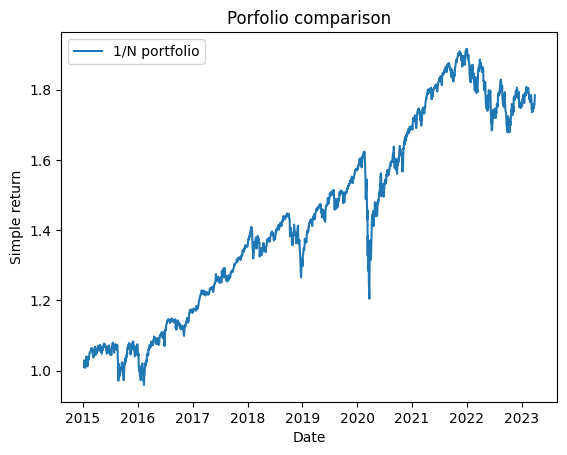

In [11]:
# 1/N portfolio
portoflio_1_N = PortfolioBacktest(get_1N_portfolio, 2, '1/N portfolio', shrinkage_cov=False)
weights_1_N = portoflio_1_N.walk_forward_backtest(ETF_log_ret_all)

# Compute simple returns (not compounded)
log_ret_1_N = portoflio_1_N.get_portfolio_log_ret()
perf_1_N = portoflio_1_N.get_portfolio_perf()

# Plot performance
portoflio_1_N.plot_portfolio_perf()

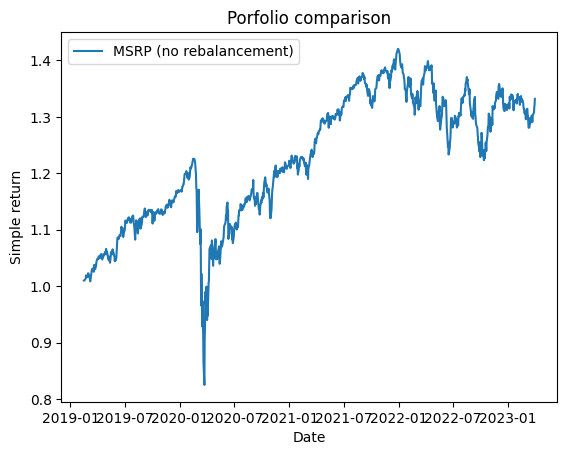

In [12]:
# MSRP with 1 rebalancement
one_rebalancement_frequency = 1042
portoflio_MSRP_1R = PortfolioBacktest(get_MSRP_portfolio, one_rebalancement_frequency, 'MSRP (no rebalancement)', shrinkage_cov=False)
weights_MRSP_1R = portoflio_MSRP_1R.walk_forward_backtest(ETF_log_ret_all)
weights_MRSP_1R.head()

# Compute simple returns (not compounded)
log_ret_MSRP_1R = portoflio_MSRP_1R.get_portfolio_log_ret()
perf_MSRP_1R = portoflio_MSRP_1R.get_portfolio_perf()

# Plot performance
portoflio_MSRP_1R.plot_portfolio_perf()

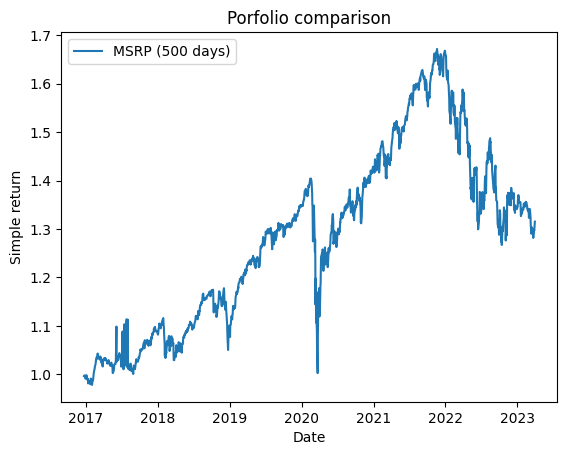

In [13]:
# MSRP with rebalancement every 500 d
rebalancing_frequency_500 = 500
portoflio_MSRP_500 = PortfolioBacktest(get_MSRP_portfolio, rebalancing_frequency_500, 'MSRP (500 days)', shrinkage_cov=False)
weights_MRSP_500 = portoflio_MSRP_500.walk_forward_backtest(ETF_log_ret_all)

# Compute simple returns (not compounded)
log_ret_MSRP_90 = portoflio_MSRP_500.get_portfolio_log_ret()
perf_MSRP_90 = portoflio_MSRP_500.get_portfolio_perf()

# Plot performance
portoflio_MSRP_500.plot_portfolio_perf()

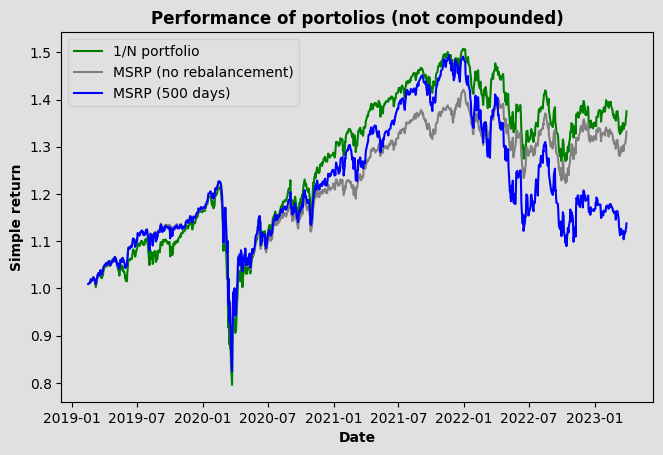

In [14]:
# Comparison of 1/N, MSRP (no rebalancement), MSRP (90 d)
fig, ax = plt.subplots()
fig.set_facecolor('#e0e0e0ff')

ax.plot(portoflio_1_N.get_portfolio_perf(1042 - 2), color='green', label=portoflio_1_N.method)
plt.plot(portoflio_MSRP_1R.get_portfolio_perf(), color='grey', label=portoflio_MSRP_1R.method)
plt.plot(portoflio_MSRP_500.get_portfolio_perf(1042-rebalancing_frequency_500), color='blue', label=portoflio_MSRP_500.method)

ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Simple return', fontweight='bold')
ax.set_facecolor('#e0e0e0ff')

ax.set_title("Performance of portolios (not compounded)", fontweight='bold')
ax.legend(facecolor=(224/255, 224/255, 224/255, 1)) #loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=3, fancybox=True, shadow=True

plt.subplots_adjust(right=1.05)
plt.show()

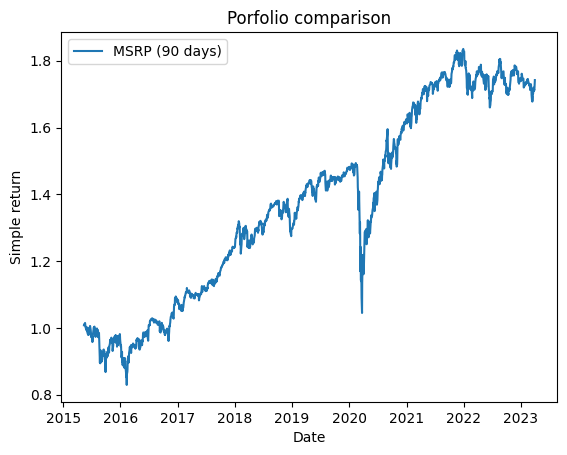

In [15]:
# MSRP with rebalancement every 90 d
rebalancing_frequency_90 = 90
portoflio_MSRP_90 = PortfolioBacktest(get_MSRP_portfolio, rebalancing_frequency_90, 'MSRP (90 days)', shrinkage_cov=False)
weights_MRSP_90 = portoflio_MSRP_90.walk_forward_backtest(ETF_log_ret_all)

# Compute simple returns (not compounded)
log_ret_MSRP_90 = portoflio_MSRP_90.get_portfolio_log_ret()
perf_MSRP_90 = portoflio_MSRP_90.get_portfolio_perf()

# Plot performance
portoflio_MSRP_90.plot_portfolio_perf()

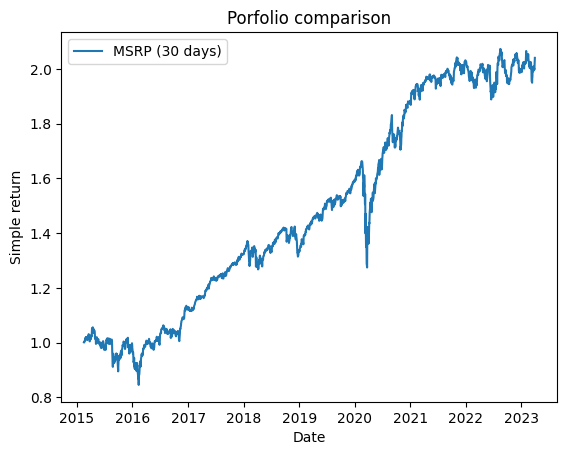

In [16]:
# MSRP with rebalancement every 30 d
rebalancing_frequency_30 = 30
portoflio_MSRP_30 = PortfolioBacktest(get_MSRP_portfolio, rebalancing_frequency_30, 'MSRP (30 days)', shrinkage_cov=False)
weights_MRSP_30 = portoflio_MSRP_30.walk_forward_backtest(ETF_log_ret_all)

# Compute simple returns (not compounded)
log_ret_MSRP_30 = portoflio_MSRP_30.get_portfolio_log_ret()
perf_MSRP_30 = portoflio_MSRP_30.get_portfolio_perf()

# Plot performance
portoflio_MSRP_30.plot_portfolio_perf()

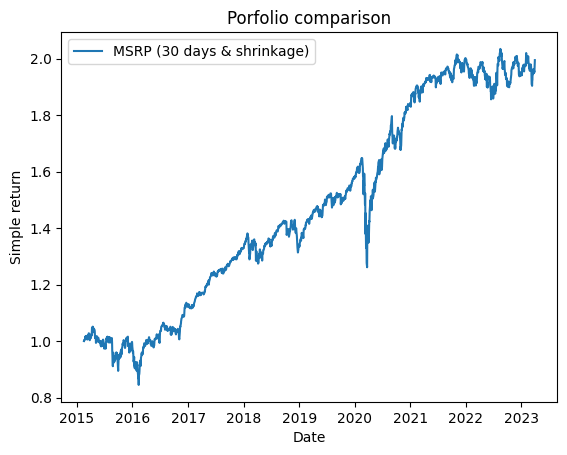

In [17]:
# MSRP with rebalancement every 30 d (shrinkage cov)
rebalancing_frequency_30 = 30
portoflio_MSRP_30_shrinkage = PortfolioBacktest(get_MSRP_portfolio, rebalancing_frequency_30, 'MSRP (30 days & shrinkage)', shrinkage_cov=True)
weights_MRSP_30_shrinkage = portoflio_MSRP_30_shrinkage.walk_forward_backtest(ETF_log_ret_all)

# Compute simple returns (not compounded)
log_ret_MSRP_30_shrinkage = portoflio_MSRP_30_shrinkage.get_portfolio_log_ret()
perf_MSRP_30_shrinkage = portoflio_MSRP_30_shrinkage.get_portfolio_perf()

# Plot performance
portoflio_MSRP_30_shrinkage.plot_portfolio_perf()

In [18]:
def ret(portreturn, days):
  annual_return = np.prod(1 +  np.array(portreturn)) ** (days / len(np.array(portreturn))) - 1
  return(annual_return)
def vol(portreturn,days):
  volatility = np.std(np.array(portreturn)) * np.sqrt(days)
  return(volatility)
def sharpe(portreturn,days):
  sharpe_ratio = np.array(ret(portreturn,days)) / np.array(vol(portreturn,days))
  return(sharpe_ratio)


In [ ]:
# Let's train LSTM model. It takes about 2-3 hours, that is why we will provide additional file
# Let's predict each six days 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ETF_prices_all)
def buymax(test, predict):
  best_stock_index = np.argmax(predict/test - 1)
  return(ETFs_names[best_stock_index])

buythis = []
for i in range(1,(int((dataset.shape[0]-1)/6))):
  train_X = np.array(dataset[:i*3])
  train_Y = np.array(dataset[3*i:6*i])
  test_X = np.array(dataset[6*i:6*i+6])
  #test_Y = np.array(dataset[6*i+1:6*i+2])
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, 7))) 
  model.add(Dense(7))  
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(train_X, train_Y, epochs=10, batch_size=2, verbose=2)
  
  predicted_stock_prices = model.predict(test_X)

  predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)
  buythis.append(buymax(ETF_prices_all[6*i:6*i+1],predicted_stock_prices[-1]))


Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 1s 518ms/step
Epoch 1/10
164/164 - 3s - loss: 0.0097 - 3s/epoch - 18ms/step
Epoch 2/10
164/164 - 0s - loss: 0.0022 - 436ms/epoch - 3ms/step
Epoch 3/10
164/164 - 0s - loss: 0.0021 - 426ms/epoch - 3ms/step
Epoch 4/10
164/164 - 0s - loss: 0.0020 - 429ms/epoch - 3ms/step
Epoch 5/10
164/164 - 0s - loss: 0.0019 - 446ms/epoch - 3ms/step
Epoch 6/10
164/164 - 1s - loss: 0.0018 - 528ms/epoch - 3ms/step
Epoch 7/10
164/164 - 1s - loss: 0.0017 - 663ms/epoch - 4ms/step
Epoch 8/10
164/164 - 1s - loss: 0.0016 - 673ms/epoch - 4ms/step
Epoch 9/10
164/164 - 1s - loss: 0.0014 - 662ms/epoch - 4ms/step
Epoch 10/10
164/164 - 1s - loss: 0.0013 - 605ms/epoch - 4ms/step
1/1 [==============================] - 1s 541ms/step
Epoch 1/10
165/165 - 2s - loss: 0.0083 - 2s/epoch - 14ms/step
Epoch 2/10
165/165 - 0s - loss: 0.0024 - 369ms/epoch - 2ms/step
Epoch 3/10
165/165 - 0s - loss: 0.0022 - 372ms/epoch - 2ms/st

In [ ]:
# Let's train LSTM model. It takes about 3-4+ hours, that is why we will provide additional file
# Let's predict each 2 days 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ETF_prices_all)
def buymax(test, predict):
  best_stock_index = np.argmax(predict/test - 1)
  return(ETFs_names[best_stock_index])

buythis2 = []
for i in range(1,(int((dataset.shape[0]-1)/2))):
  train_X = np.array(dataset[:i])
  train_Y = np.array(dataset[i:2*i])
  test_X = np.array(dataset[2*i:2*i+1])
  test_Y = np.array(dataset[2*i+1:2*i+2])
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, 7))) 
  model.add(Dense(7))  
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(train_X, train_Y, epochs=5, batch_size=2, verbose=2)
  
  predicted_stock_prices = model.predict(test_X)

  predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)
  buythis2.append(buymax(ETF_prices_all[2*i:2*i+1],predicted_stock_prices))


Epoch 1/5


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame({"BUY":buythis30})
df.to_excel("BUY30.xlsx", index=False)

In [ ]:
# Download data
from google.colab import files
files.download('BUY30.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Rebalancing each six days 
buythis2 = pd.read_excel('BUY6.xlsx')
buythis2 = buythis2.values.tolist()
buythis = []
for i in range(len(buythis2)):
  buythis.append(buythis2[i][0])

buythis

['Momentum',
 'Momentum',
 'Value',
 'Value',
 'Momentum',
 'Value',
 'Min volatility',
 'Momentum',
 'Value',
 'Growth',
 'Momentum',
 'Size',
 'Min volatility',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'Size',
 'Value',
 'Size',
 'Value',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'Growth',
 'Growth',
 'Growth',
 'Momentum',
 'Size',
 'Quality',
 'Size',
 'Quality',
 'Size',
 'Size',
 'Growth',
 'Growth',
 'Quality',
 'Growth',
 'Size',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Momentum',
 'Momentum',
 'Growth',
 'Growth',
 'Momentum',
 'Momentum',
 'High dividend',
 'Quality',
 'Growth',
 'Size',
 'Growth',
 'Quality',
 'Growth',
 'Growth',
 'Quality',
 'Quality',
 'Quality',
 'Quality',
 'Quality',
 'Quality',
 'Growth',
 'Min volatility',
 'Quality',
 'High dividend',
 'Min volatility',
 'Min volatility',
 'Quality',
 'Quality'

In [20]:
#Let's get data for price each six days 
myport = ETF_prices_all[:]
myport = myport[0::6]
myport_log_ret_all = (myport.pct_change() + 1).apply(np.log)

# Remove the first line
myport_log_ret_all = myport_log_ret_all.tail(-1)

# Convert to numpy arraym
myport_log_ret_all = myport_log_ret_all.to_numpy()
myport_log_ret_all

array([[-0.00645052, -0.01406125,  0.00396545, ..., -0.00824508,
         0.00492495, -0.01361745],
       [ 0.00061604, -0.00469117,  0.00409651, ...,  0.00471981,
         0.00661044, -0.00048641],
       [ 0.01193956, -0.01592096, -0.00438919, ...,  0.01402706,
        -0.00562813,  0.00068092],
       ...,
       [-0.07602704, -0.0587231 , -0.04906823, ..., -0.03283027,
        -0.03066673, -0.03872678],
       [ 0.02107746,  0.01726927,  0.01504772, ...,  0.0247998 ,
         0.02167792,  0.05929873],
       [ 0.00660396,  0.00639396,  0.00895507, ...,  0.01096229,
         0.01483429,  0.00571674]])

In [21]:
dataforport = myport.index
dfport = pd.DataFrame(myport_log_ret_all, index = myport.index[1:], columns = myport.columns )
dfport

,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
2015-01-12,-0.006451,-0.014061,0.003965,0.009128,-0.008245,0.004925,-0.013617
2015-01-20,0.000616,-0.004691,0.004097,0.016129,0.004720,0.006610,-0.000486
2015-01-28,0.011940,-0.015921,-0.004389,0.013555,0.014027,-0.005628,0.000681
2015-02-05,0.011648,0.030642,0.017154,0.002782,0.012306,0.015341,0.028465
2015-02-13,0.005848,0.014390,0.010752,0.010592,0.011400,0.002414,0.021130
...,...,...,...,...,...,...,...
2023-02-23,-0.038377,-0.023133,-0.018707,-0.014002,-0.027802,-0.017156,-0.043550
2023-03-03,0.009754,0.005939,0.004305,0.000229,0.008847,-0.001956,0.011235
2023-03-13,-0.076027,-0.058723,-0.049068,-0.049094,-0.032830,-0.030667,-0.038727
2023-03-21,0.021077,0.017269,0.015048,0.007555,0.024800,0.021678,0.059299


In [22]:
# First weight for equal portfolio and then based on our prediction.
# We need to buy equal weights
wei = np.array([1/7,1/7,1/7,1/7,1/7,1/7,1/7])
ret = dfport.iloc[0]*wei
eq = np.sum(ret)
newport = [eq]
counter = 1
for i in buythis:
  newport.append(dfport.iloc[:counter][i][-1])
  counter = counter+1

newportdf = pd.DataFrame(newport, index = myport.index[1:])
newportdfsum = newportdf.cumsum()+1
newportdfsum

,0
2015-01-12,0.996521
2015-01-20,1.000486
2015-01-28,1.004583
2015-02-05,0.988662
2015-02-13,1.019304
...,...
2023-02-23,0.641775
2023-03-03,0.627773
2023-03-13,0.639009
2023-03-21,0.589915


In [27]:
# Let's do the same for rebalancing each 2 days 
buythis1 = pd.read_excel('BUY.xlsx')
buythis1 = buythis1.values.tolist()
buythis0 = []
for i in range(len(buythis1)):
  buythis0.append(buythis1[i][0])

buythis0

['Momentum',
 'Min volatility',
 'Min volatility',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Min volatility',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Growth',
 'Min volatility',
 'High dividend',
 'Min volatility',
 'Min volatility',
 'Growth',
 'Size',
 'Size',
 'Quality',
 'Growth',
 'Growth',
 'Quality',
 'Value',
 'Growth',
 'Growth',
 'Min volatility',
 'Growth',
 'Momentum',
 'Momentum',
 'Value',
 'Momentum',
 'Momentum',
 'Min volatility',
 'Size',
 'Size',
 'Size',
 'Momentum',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'Size',
 'Min volatility',
 'Size',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'High dividend',
 'Quality',
 'Quality',
 'High dividend',
 'High dividend',
 'Size',
 'Value'

In [28]:
myport = ETF_prices_all[:]
myport2 = myport[0::2]
myport2
myport2_log_ret_all = (myport2.pct_change() + 1).apply(np.log)

# Remove the first line
myport2_log_ret_all = myport2_log_ret_all.tail(-1)

# Convert to numpy arraym
myport2_log_ret_all = myport2_log_ret_all.to_numpy()
myport2_log_ret_all

array([[-0.01620533, -0.02747164, -0.0215702 , ..., -0.0229395 ,
        -0.01216952, -0.02712714],
       [ 0.02398277,  0.02936278,  0.03661457, ...,  0.02450227,
         0.02735858,  0.02990515],
       [-0.01422796, -0.01595239, -0.01107892, ..., -0.00980785,
        -0.01026411, -0.01639546],
       ...,
       [ 0.0140334 ,  0.01725724,  0.02019522, ..., -0.0073045 ,
         0.01693391, -0.00191528],
       [ 0.01731269,  0.01249325,  0.01183702, ...,  0.00861767,
         0.01038749,  0.0129606 ],
       [ 0.02143981,  0.01451366,  0.00990211, ...,  0.01701577,
         0.01565667,  0.02586892]])

In [29]:
dataforport2 = myport2.index
dfport2 = pd.DataFrame(myport2_log_ret_all, index = myport2.index[1:], columns = myport2.columns )
dfport2

,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
2015-01-06,-0.016205,-0.027472,-0.021570,-0.011651,-0.022940,-0.012170,-0.027127
2015-01-08,0.023983,0.029363,0.036615,0.033609,0.024502,0.027359,0.029905
2015-01-12,-0.014228,-0.015952,-0.011079,-0.012830,-0.009808,-0.010264,-0.016395
2015-01-14,-0.007579,-0.010738,-0.006765,-0.013481,-0.009109,-0.004431,-0.005754
2015-01-16,0.001706,0.005805,0.005446,0.031491,0.005950,0.009332,0.000685
...,...,...,...,...,...,...,...
2023-03-21,0.025169,0.024849,0.030250,0.002752,0.013771,0.012922,0.019013
2023-03-23,-0.024742,-0.023357,-0.023077,-0.016746,0.009649,-0.012487,-0.005329
2023-03-27,0.014033,0.017257,0.020195,0.015671,-0.007304,0.016934,-0.001915
2023-03-29,0.017313,0.012493,0.011837,0.003462,0.008618,0.010387,0.012961


In [30]:
# First weight for equal portfolio and then based on our prediction.
# We need to buy equal weights
wei = np.array([1/7,1/7,1/7,1/7,1/7,1/7,1/7])
ret = dfport2.iloc[0]*wei
eq = np.sum(ret)
newport2 = [eq]
counter = 1
for i in buythis0:
  newport2.append(dfport2.iloc[:counter][i][-1])
  counter = counter+1

newportdf2 = pd.DataFrame(newport2, index = myport2.index[1:])
newportdfsum2 = newportdf2.cumsum()+1
newportdfsum2


,0
2015-01-06,0.980124
2015-01-08,0.958554
2015-01-12,0.985912
2015-01-14,0.975648
2015-01-16,0.968883
...,...
2023-03-21,-0.099353
2023-03-23,-0.074504
2023-03-27,-0.079832
2023-03-29,-0.065799


We got that if we will try to predict price for the next two days аfter a few years we will be left with nothing 

In [72]:
# Let's train LSTM model. It takes about 15-20 min, that is why we will provide additional file
# Let's predict each 30 days 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ETF_prices_all)
def buymax(test, predict):
  best_stock_index = np.argmax(predict/test - 1)
  return(ETFs_names[best_stock_index])

buythis30 = []
check = []
predicted_price_list = []
for i in range(1,(int((dataset.shape[0]-1)/30))):
  train_X = np.array(dataset[:i*15])
  train_Y = np.array(dataset[15*i:30*i])
  test_X = np.array(dataset[30*i:30*i+30])
  #test_Y = np.array(dataset[30*i+15:30*i+30])
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, 7))) 
  model.add(Dense(7))  
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(train_X, train_Y, epochs=5, batch_size=1, verbose=2)
  
  predicted_stock_prices = model.predict(test_X)
  predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)
  predicted_price_list.extend(predicted_stock_prices)

  check.append(predicted_stock_prices[-1])
  buythis30.append(buymax(ETF_prices_all[30*i:30*i+1],predicted_stock_prices[-1]))

new_data = pd.DataFrame(predicted_price_list, columns=ETF_prices_all.columns)

ETF_prices_all2 = pd.concat([ETF_prices_all.iloc[:(i+1)*30], new_data, ETF_prices_all.iloc[(i+1)*30:]]).reset_index(drop=False)

Epoch 1/5
15/15 - 3s - loss: 0.0022 - 3s/epoch - 174ms/step
Epoch 2/5
15/15 - 0s - loss: 9.2676e-04 - 45ms/epoch - 3ms/step
Epoch 3/5
15/15 - 0s - loss: 2.9394e-04 - 42ms/epoch - 3ms/step
Epoch 4/5
15/15 - 0s - loss: 8.6575e-05 - 40ms/epoch - 3ms/step
Epoch 5/5
15/15 - 0s - loss: 5.5980e-05 - 51ms/epoch - 3ms/step
1/1 [==============================] - 1s 510ms/step
Epoch 1/5
30/30 - 2s - loss: 0.0040 - 2s/epoch - 70ms/step
Epoch 2/5
30/30 - 0s - loss: 0.0011 - 83ms/epoch - 3ms/step
Epoch 3/5
30/30 - 0s - loss: 2.3830e-04 - 104ms/epoch - 3ms/step
Epoch 4/5
30/30 - 0s - loss: 7.4860e-05 - 88ms/epoch - 3ms/step
Epoch 5/5
30/30 - 0s - loss: 6.7849e-05 - 80ms/epoch - 3ms/step
1/1 [==============================] - 0s 486ms/step
Epoch 1/5
45/45 - 2s - loss: 0.0030 - 2s/epoch - 47ms/step
Epoch 2/5
45/45 - 0s - loss: 3.1153e-04 - 124ms/epoch - 3ms/step
Epoch 3/5
45/45 - 0s - loss: 7.6076e-05 - 124ms/epoch - 3ms/step
Epoch 4/5
45/45 - 0s - loss: 7.2953e-05 - 108ms/epoch - 2ms/step
Epoch 5/5
45

In [87]:
#new_data.to_excel("new.xlsx", index=True)
#files.download('new.xlsx')
ETF_prices_all2 = pd.read_excel('ETF.xlsx')
new_data = pd.read_excel('new.xlsx')
new_data = new_data.drop("Unnamed: 0", axis = 1)
new_data

,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
0,57.654549,68.005844,62.421101,21.725515,26.168600,35.178116,97.691284
1,57.663151,68.030937,62.439487,21.727863,26.173307,35.180225,97.759369
2,57.668671,68.063492,62.452732,21.732481,26.175434,35.182652,97.824348
3,57.697227,68.071693,62.423893,21.736341,26.174055,35.162067,97.828949
4,57.643482,68.057129,62.443878,21.735182,26.167858,35.183426,97.713776
...,...,...,...,...,...,...,...
2035,147.397888,172.992752,189.571106,54.464027,61.674759,83.728088,340.394440
2036,146.960358,172.206650,188.875870,54.152519,61.464462,83.566963,338.916687
2037,146.915161,172.150864,188.791580,54.149723,61.461124,83.547760,338.801971
2038,146.441544,171.253922,188.079941,53.791718,61.239223,83.399948,337.264587


In [88]:
# Let's do the same for rebalancing each 30 days 
buythis300 = pd.read_excel('BUY30.xlsx')
buythis300 = buythis300.values.tolist()
buythis30 = []
for i in range(len(buythis300)):
  buythis30.append(buythis300[i][0])

buythis30

['Momentum',
 'Value',
 'High dividend',
 'High dividend',
 'Value',
 'Value',
 'Value',
 'Value',
 'Growth',
 'Growth',
 'Growth',
 'Value',
 'Quality',
 'Quality',
 'Min volatility',
 'Quality',
 'Min volatility',
 'Min volatility',
 'Min volatility',
 'High dividend',
 'Growth',
 'High dividend',
 'Min volatility',
 'Growth',
 'Growth',
 'Momentum',
 'Growth',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Momentum',
 'Min volatility',
 'Min volatility',
 'Min volatility',
 'Value',
 'Size',
 'Min volatility',
 'Min volatility',
 'Momentum',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Size',
 'Size',
 'Growth',
 'Growth',
 'Growth',
 'Growth',
 'Quality',
 'Value',
 'Growth',
 'Size',
 'High dividend']

In [89]:
myport = ETF_prices_all[:]
myport30 = myport[0::30]
myport30_log_ret_all = (myport30.pct_change() + 1).apply(np.log)

# Remove the first line
myport30_log_ret_all = myport30_log_ret_all.tail(-1)

# Convert to numpy arraym
myport30_log_ret_all = myport30_log_ret_all.to_numpy()
myport30_log_ret_all

array([[ 2.36015064e-02,  1.03590190e-02,  3.15784283e-02,
         5.21857828e-02,  3.42077694e-02,  2.36624043e-02,
         3.61723198e-02],
       [-5.78694787e-03, -2.13748780e-02,  7.67337116e-03,
         1.18398573e-02, -7.56018098e-04, -4.90670642e-03,
        -4.48580084e-03],
       [ 7.07230489e-03,  2.80070623e-02,  1.41809669e-03,
        -7.72555878e-03,  3.31008059e-02,  3.64294332e-03,
         9.27830377e-03],
       [ 5.85471839e-03, -4.97684129e-04,  3.43558725e-02,
         4.55168652e-03, -3.48142598e-03, -3.68910611e-03,
         1.06149989e-02],
       [-7.51762282e-03, -1.37572401e-02, -5.49556397e-04,
         6.33770291e-03, -9.40529419e-03,  2.53486086e-02,
        -1.19173929e-03],
       [-4.49115232e-02, -6.78081769e-02, -2.85791987e-02,
        -9.01340614e-02, -6.34890984e-02, -4.43542811e-02,
        -4.77221542e-02],
       [ 4.50362960e-02,  6.10750634e-02,  3.71416704e-02,
         1.09352544e-01,  6.08917058e-02,  4.96541512e-02,
         5.3631789

In [90]:
dataforport30 = myport30.index
dfport30 = pd.DataFrame(myport30_log_ret_all, index = myport30.index[1:], columns = myport30.columns )
dfport30

,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
2015-02-13,0.023602,0.010359,0.031578,0.052186,0.034208,0.023662,0.036172
2015-03-27,-0.005787,-0.021375,0.007673,0.011840,-0.000756,-0.004907,-0.004486
2015-05-13,0.007072,0.028007,0.001418,-0.007726,0.033101,0.003643,0.009278
2015-06-25,0.005855,-0.000498,0.034356,0.004552,-0.003481,-0.003689,0.010615
2015-08-06,-0.007518,-0.013757,-0.000550,0.006338,-0.009405,0.025349,-0.001192
...,...,...,...,...,...,...,...
2022-09-21,-0.091348,-0.052954,-0.027627,-0.018785,-0.085088,-0.070746,-0.118715
2022-11-02,0.000058,0.048450,0.060455,0.018018,-0.003221,0.012366,-0.066539
2022-12-14,0.068033,0.054465,0.021836,-0.005603,0.095613,0.067501,0.071264
2023-01-30,0.025290,-0.001414,-0.026703,-0.042651,0.006047,-0.025249,0.015633


In [91]:
# First weight for equal portfolio and then based on our prediction.
# We need to buy equal weights
wei = np.array([1/7,1/7,1/7,1/7,1/7,1/7,1/7])
ret = dfport30.iloc[0]*wei
eq = np.sum(ret)
newport3 = [eq]
counter = 1
for i in buythis30:
  newport3.append(dfport30.iloc[:counter][i][-1])
  counter = counter+1

newportdf3 = pd.DataFrame(newport3, index = myport30.index[1:])
newportdfsum3 = newportdf3.cumsum()+1
newportdfsum3

,0
2015-02-13,1.030252
2015-03-27,1.061831
2015-05-13,1.040456
2015-06-25,1.032730
2015-08-06,1.037282
...,...
2022-09-21,1.329240
2022-11-02,1.276286
2022-12-14,1.209748
2023-01-30,1.277781


For 30 days the results are better. 

##### Now let's combine methods with calcuations and predictions 

In [92]:
# Предсказанные цены
predicted_prices_df = new_data
# Актуальные цены
actual_prices_df = ETF_prices_all.copy()  # Ваш датафрейм с актуальными ценами


# Создание пустого списка для хранения весов портфеля
portfolio_weights = []

# Цикл для обработки каждого блока актуальных цен
for i in range(0,(int((dataset.shape[0]-1)/30))):
    predicted_prices_block = predicted_prices_df[i:(i+1)*30]  # Получение блока предсказанных цен
    df = pd.concat([actual_prices_df[:(i+1)*30],predicted_prices_df[i:(i+1)*30]])
    predicted_prices_block = (df.pct_change() + 1).apply(np.log)
    predicted_prices_block = predicted_prices_block.tail(-1)
    predicted_prices_block = predicted_prices_block.to_numpy()
    weights , lol = get_MSRP_portfolio(predicted_prices_block)
    # Расчет весов для maximum sharpe ratio с учетом предсказаний
    # Ваш код для расчета весов для maximum sharpe ratio с учетом предсказанных цен

    portfolio_weights.append(weights)  # Добавление весов в список
    df = actual_prices_df
portfolio_weights

[                 Size         Value      Momentum  High dividend  \
 Weights  1.224811e-18  5.222439e-17  1.168703e-17       0.929353   
 
               Quality  Min volatility        Growth  
 Weights -5.939489e-17        0.070647 -8.591577e-18  ,
                  Size         Value      Momentum  High dividend   Quality  \
 Weights  7.760960e-19  2.358021e-17  5.948444e-18       0.754157  0.032136   
 
          Min volatility        Growth  
 Weights        0.213707 -4.014426e-19  ,
                  Size         Value      Momentum  High dividend   Quality  \
 Weights  1.492005e-17  2.780031e-19 -5.219488e-18       0.877327  0.064475   
 
          Min volatility    Growth  
 Weights    1.885946e-18  0.058198  ,
                  Size         Value      Momentum  High dividend   Quality  \
 Weights -4.591104e-17  4.465463e-17  2.643734e-17       0.477195  0.522805   
 
          Min volatility        Growth  
 Weights    5.069377e-18 -2.471981e-17  ,
              Size         V

In [93]:
results = []
for i in range(len(portfolio_weights)):
  results.append(portfolio_weights[i] *myport30_log_ret_all[i] )
final = pd.concat(results)
final_sum = final.sum(axis=1)
dataforport30 = myport30.index
dfport30 = pd.DataFrame(final_sum )
dfport30 = dfport30.set_index(myport30.index[1:])
newportdfsum30 = dfport30.cumsum()+1
newportdfsum30


,0
2015-02-13,1.050171
2015-03-27,1.058027
2015-05-13,1.053923
2015-06-25,1.054275
2015-08-06,1.050380
...,...
2022-09-21,1.426711
2022-11-02,1.393512
2022-12-14,1.453128
2023-01-30,1.439449


Now the results are better, but anyway it is still bad in comparison with strategy buy-hold

In [94]:
#ETF_prices_all2.set_index('index', inplace=True)
new_data

,Size,Value,Momentum,High dividend,Quality,Min volatility,Growth
0,57.654549,68.005844,62.421101,21.725515,26.168600,35.178116,97.691284
1,57.663151,68.030937,62.439487,21.727863,26.173307,35.180225,97.759369
2,57.668671,68.063492,62.452732,21.732481,26.175434,35.182652,97.824348
3,57.697227,68.071693,62.423893,21.736341,26.174055,35.162067,97.828949
4,57.643482,68.057129,62.443878,21.735182,26.167858,35.183426,97.713776
...,...,...,...,...,...,...,...
2035,147.397888,172.992752,189.571106,54.464027,61.674759,83.728088,340.394440
2036,146.960358,172.206650,188.875870,54.152519,61.464462,83.566963,338.916687
2037,146.915161,172.150864,188.791580,54.149723,61.461124,83.547760,338.801971
2038,146.441544,171.253922,188.079941,53.791718,61.239223,83.399948,337.264587


#### Let's do the same but for 90 days period

In [68]:
# It takes about 10 min
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ETF_prices_all)
def buymax(test, predict):
  best_stock_index = np.argmax(predict/test - 1)
  return(ETFs_names[best_stock_index])

buythis_90 = []
check_90 = []
predicted_price_list_90 = []
for i in range(1,(int((dataset.shape[0]-1)/90))):
  train_X = np.array(dataset[:i*45])
  train_Y = np.array(dataset[45*i:90*i])
  test_X = np.array(dataset[90*i:90*i+90])
  #test_Y = np.array(dataset[30*i+15:30*i+30])
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, 7))) 
  model.add(Dense(7))  
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(train_X, train_Y, epochs=5, batch_size=1, verbose=2)
  
  predicted_stock_prices = model.predict(test_X)
  predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)
  predicted_price_list_90.extend(predicted_stock_prices)

  check_90.append(predicted_stock_prices[-1])
  buythis_90.append(buymax(ETF_prices_all[90*i:90*i+1],predicted_stock_prices[-1]))

new_data_90 = pd.DataFrame(predicted_price_list_90, columns=ETF_prices_all.columns)

ETF_prices_all_90 = pd.concat([ETF_prices_all.iloc[:(i+1)*90], new_data_90, ETF_prices_all.iloc[(i+1)*90:]]).reset_index(drop=False)
myport = ETF_prices_all[:]
myport90 = myport[0::90]
myport90_log_ret_all = (myport90.pct_change() + 1).apply(np.log)

# Remove the first line
myport90_log_ret_all = myport90_log_ret_all.tail(-1)

# Convert to numpy arraym
myport90_log_ret_all = myport90_log_ret_all.to_numpy()
dataforport90 = myport90.index
dfport90 = pd.DataFrame(myport90_log_ret_all, index = myport90.index[1:], columns = myport90.columns )

wei = np.array([1/7,1/7,1/7,1/7,1/7,1/7,1/7])
ret = dfport90.iloc[0]*wei
eq = np.sum(ret)
newport90 = [eq]
counter = 1
for i in buythis_90:
  newport90.append(dfport90.iloc[:counter][i][-1])
  counter = counter+1

newportdf90 = pd.DataFrame(newport90, index = myport90.index[1:])
newportdfsum90 = newportdf90.cumsum()+1
newportdfsum90


Epoch 1/5
45/45 - 2s - loss: 0.0026 - 2s/epoch - 54ms/step
Epoch 2/5
45/45 - 0s - loss: 2.3311e-04 - 125ms/epoch - 3ms/step
Epoch 3/5
45/45 - 0s - loss: 6.7714e-05 - 120ms/epoch - 3ms/step
Epoch 4/5
45/45 - 0s - loss: 6.7826e-05 - 117ms/epoch - 3ms/step
Epoch 5/5
45/45 - 0s - loss: 6.6900e-05 - 127ms/epoch - 3ms/step
3/3 [==============================] - 1s 5ms/step
Epoch 1/5
90/90 - 4s - loss: 0.0014 - 4s/epoch - 41ms/step
Epoch 2/5
90/90 - 0s - loss: 5.1801e-04 - 246ms/epoch - 3ms/step
Epoch 3/5
90/90 - 0s - loss: 5.2343e-04 - 259ms/epoch - 3ms/step
Epoch 4/5
90/90 - 0s - loss: 5.0818e-04 - 243ms/epoch - 3ms/step
Epoch 5/5
90/90 - 0s - loss: 4.9015e-04 - 233ms/epoch - 3ms/step
3/3 [==============================] - 1s 4ms/step
Epoch 1/5
135/135 - 2s - loss: 9.0562e-04 - 2s/epoch - 18ms/step
Epoch 2/5
135/135 - 0s - loss: 6.2614e-04 - 331ms/epoch - 2ms/step
Epoch 3/5
135/135 - 0s - loss: 6.2322e-04 - 389ms/epoch - 3ms/step
Epoch 4/5
135/135 - 0s - loss: 6.1150e-04 - 344ms/epoch - 3ms

,0
2015-05-13,1.038395
2015-09-18,1.094695
2016-01-27,1.015450
2016-06-07,0.957103
2016-10-12,1.071628
2017-02-20,1.072844
2017-06-30,1.133079
2017-11-06,1.090145
2018-03-15,1.172598
2018-07-25,1.271047


In [69]:
predicted_prices_df = new_data_90
actual_prices_df = ETF_prices_all.copy()  
portfolio_weights_90 = []

for i in range(0,(int((dataset.shape[0]-1)/90))):
    predicted_prices_block = predicted_prices_df[i:(i+1)*90] 
    df = pd.concat([actual_prices_df[:(i+1)*90],predicted_prices_df[i:(i+1)*90]])
    predicted_prices_block = (df.pct_change() + 1).apply(np.log)
    predicted_prices_block = predicted_prices_block.tail(-1)
    predicted_prices_block = predicted_prices_block.to_numpy()
    weights , lol = get_MSRP_portfolio(predicted_prices_block)
   
    portfolio_weights_90.append(weights)  
    df = actual_prices_df
results90 = []
for i in range(len(portfolio_weights_90)):
  results90.append(portfolio_weights_90[i] *myport90_log_ret_all[i] )
final_90 = pd.concat(results90)
final_sum_90 = final_90.sum(axis=1)
dataforport90 = myport90.index
dfport900 = pd.DataFrame(final_sum_90)
dfport900 = dfport900.set_index(myport90.index[1:])
newportdfsum900 = dfport900.cumsum()+1
newportdfsum900

,0
2015-05-13,1.054871
2015-09-18,1.047619
2016-01-27,1.054639
2016-06-07,1.156717
2016-10-12,1.177882
2017-02-20,1.268217
2017-06-30,1.255636
2017-11-06,1.311998
2018-03-15,1.351483
2018-07-25,1.390740


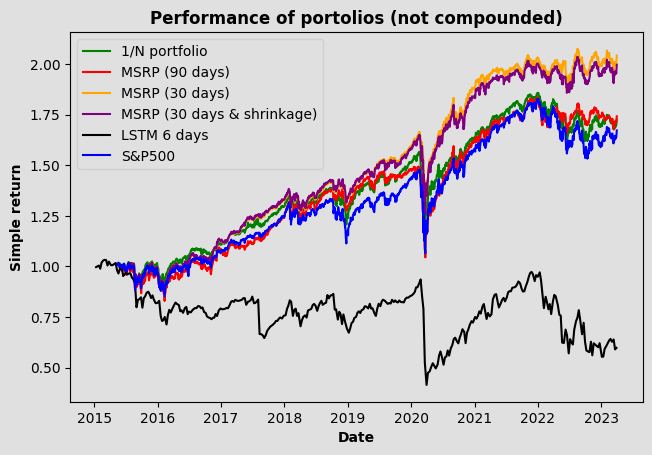

In [70]:
fig, ax = plt.subplots()
fig.set_facecolor('#e0e0e0ff')

plt.plot(portoflio_1_N.get_portfolio_perf(90 - 2), color='green', label=portoflio_1_N.method)
plt.plot(portoflio_MSRP_90.get_portfolio_perf(), color='red', label=portoflio_MSRP_90.method)
plt.plot(portoflio_MSRP_30.get_portfolio_perf(90 - 30), color='orange', label=portoflio_MSRP_30.method)
plt.plot(portoflio_MSRP_30_shrinkage.get_portfolio_perf(90 - 30), color='purple', label=portoflio_MSRP_30_shrinkage.method)
plt.plot(newportdfsum, color = "black", label="LSTM 6 days")


plt.plot(getSP500_perf(start_from=90), color='blue', label='S&P500')

ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Simple return', fontweight='bold')
ax.set_facecolor('#e0e0e0ff')

ax.set_title("Performance of portolios (not compounded)", fontweight='bold')
ax.legend(facecolor=(224/255, 224/255, 224/255, 1)) #loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=3, fancybox=True, shadow=True

plt.subplots_adjust(right=1.02)
plt.show()

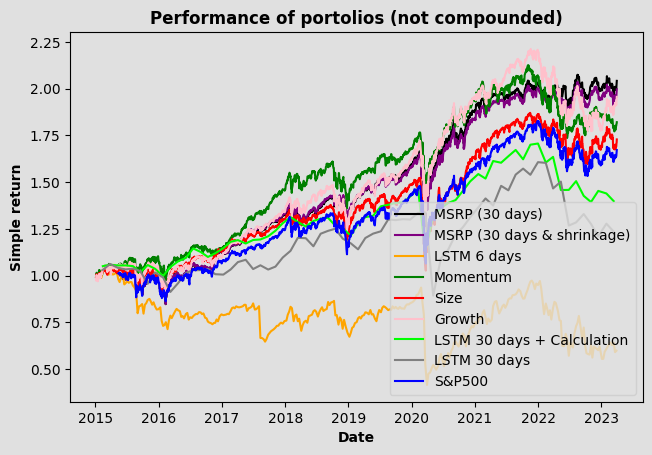

In [95]:
fig, ax = plt.subplots()
fig.set_facecolor('#e0e0e0ff')

plt.plot(portoflio_MSRP_30.get_portfolio_perf(90 - 30), color='black', label=portoflio_MSRP_30.method)
plt.plot(portoflio_MSRP_30_shrinkage.get_portfolio_perf(90 - 30), color='purple', label=portoflio_MSRP_30_shrinkage.method)
plt.plot(newportdfsum, color = "orange", label="LSTM 6 days")
plt.plot(ETFs_return_df["Momentum"], color = "green", label="Momentum")
plt.plot(ETFs_return_df["Size"], color = "red", label="Size")
plt.plot(ETFs_return_df["Growth"], color = "pink", label="Growth")
plt.plot(newportdfsum30, color = "lime", label="LSTM 30 days + Calculation")
plt.plot(newportdfsum3, color = "gray", label="LSTM 30 days")

plt.plot(getSP500_perf(start_from=90), color='blue', label='S&P500')

ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Simple return', fontweight='bold')
ax.set_facecolor('#e0e0e0ff')

ax.set_title("Performance of portolios (not compounded)", fontweight='bold')
ax.legend(facecolor=(224/255, 224/255, 224/255, 1)) #loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=3, fancybox=True, shadow=True

plt.subplots_adjust(right=1.02)
plt.show()

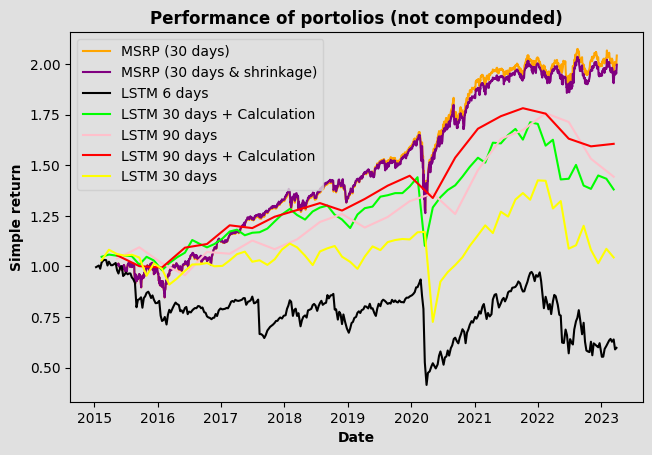

In [65]:
fig, ax = plt.subplots()
fig.set_facecolor('#e0e0e0ff')

plt.plot(portoflio_MSRP_30.get_portfolio_perf(90 - 30), color='orange', label=portoflio_MSRP_30.method)
plt.plot(portoflio_MSRP_30_shrinkage.get_portfolio_perf(90 - 30), color='purple', label=portoflio_MSRP_30_shrinkage.method)
plt.plot(newportdfsum, color = "black", label="LSTM 6 days")
plt.plot(newportdfsum30, color = "lime", label="LSTM 30 days + Calculation")
plt.plot(newportdfsum90, color = "pink", label="LSTM 90 days")
plt.plot(newportdfsum900, color = "red", label="LSTM 90 days + Calculation")
plt.plot(newportdfsum3, color = "yellow", label="LSTM 30 days")




ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Simple return', fontweight='bold')
ax.set_facecolor('#e0e0e0ff')

ax.set_title("Performance of portolios (not compounded)", fontweight='bold')
ax.legend(facecolor=(224/255, 224/255, 224/255, 1)) #loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=3, fancybox=True, shadow=True

plt.subplots_adjust(right=1.02)
plt.show()

In [70]:
newportdfsum

list

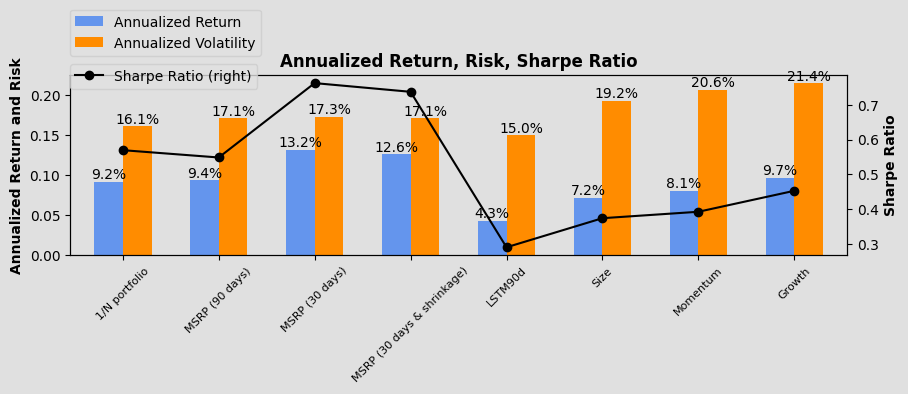

In [75]:
SR_1_N = portoflio_1_N.get_sharpe_ratio(90 - 2)
SR_MSRP_90 = portoflio_MSRP_90.get_sharpe_ratio()
SR_MSRP_30 = portoflio_MSRP_30.get_sharpe_ratio(90 - 30)
SR_MSRP_30_shrinkage = portoflio_MSRP_30_shrinkage.get_sharpe_ratio(90 - 30)

SR_all = pd.concat([SR_1_N, SR_MSRP_90, SR_MSRP_30, SR_MSRP_30_shrinkage], axis=0)
lstm = [sharpe(newport90,252/90), ret(newport90,252/90), vol(newport90,252/90)]
size = [sharpe(ETFs_return["Size"],252), ret(ETFs_return["Size"],252), vol(ETFs_return["Size"],252)]
momentum = [sharpe(ETFs_return["Momentum"],252), ret(ETFs_return["Momentum"],252), vol(ETFs_return["Momentum"],252)]
growth = [sharpe(ETFs_return["Growth"],252), ret(ETFs_return["Growth"],252), vol(ETFs_return["Growth"],252)]
SR_all.loc[len(SR_all)] = lstm
SR_all.loc[len(SR_all)] = size
SR_all.loc[len(SR_all)] = momentum
SR_all.loc[len(SR_all)] = growth
names = ["1/N", 'MSRP90d', "MSRP30d","MSRP30dshr", "LSTM90d", "Size","Momentum", "Growth"]
SR_all = SR_all.rename(index = dict(enumerate(names)))
SR_all

SR_all_bars = SR_all.plot(y=['Annualized Return','Annualized Volatility'], kind="bar", color=["cornflowerblue", "darkorange"], width=0.6)
SR_all_bars.set_ylabel('Annualized Return and Risk', fontweight='bold')
SR_all_bars.set_facecolor('#e0e0e0ff')


SR_all_SR = SR_all['Sharpe Ratio'].plot(secondary_y=True, color='k', marker='o')
SR_all_SR.set_ylabel('Sharpe Ratio', fontweight='bold')

SR_all_bars.legend(bbox_to_anchor=(0.255, 1.4)).get_frame().set_facecolor('#e0e0e0ff')
SR_all_SR.legend(bbox_to_anchor=(0.25, 1.1)).get_frame().set_facecolor('#e0e0e0ff')


fig = SR_all_bars.get_figure()
fig.patch.set_facecolor('#e0e0e0ff')
x_axis = SR_all_bars.xaxis
x_labels = x_axis.get_ticklabels()
for label in x_labels:
    label.set_fontsize(8)  
    label.set_rotation(45)  

plt.tight_layout()  

SR_all_bars.set_title("Annualized Return, Risk, Sharpe Ratio", fontweight='bold')

for container in SR_all_bars.containers:
    SR_all_bars.bar_label(container, labels=[f"{val*100:.1f}%" for val in container.datavalues])

plt.subplots_adjust(right=1.35)
plt.show()


In [78]:
SR_all

,0
2015-01-12,-0.003479
2015-01-20,0.003966
2015-01-28,0.004096
2015-02-05,-0.015921
2015-02-13,0.030642
...,...
2023-02-23,0.007525
2023-03-03,-0.014002
2023-03-13,0.011235
2023-03-21,-0.049094


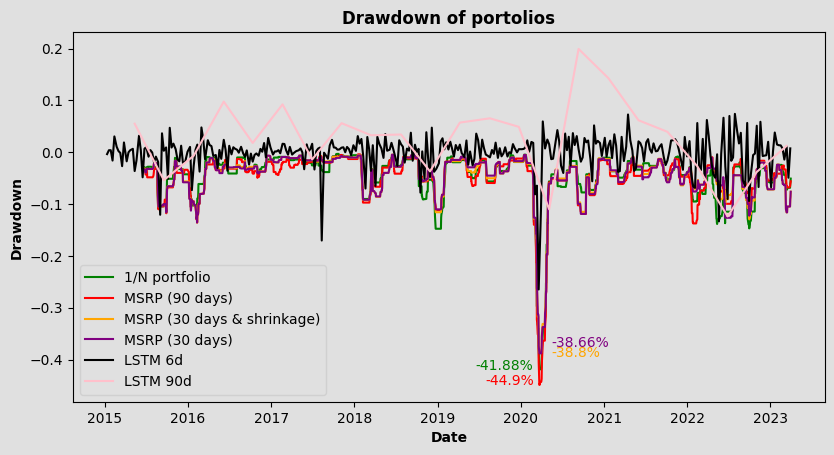

In [80]:
fig, ax = plt.subplots()
fig.set_facecolor('#e0e0e0ff')

rolling_window = 30

MDD_1_N_df, MDD_1_N = portoflio_1_N.get_MDD(rolling_window=rolling_window, start_from=90-2)
MDD_MSRP_90_df, MDD_MSRP_90 = portoflio_MSRP_90.get_MDD(rolling_window=rolling_window)
MDD_MSRP_30_df, MDD_MSRP_30 = portoflio_MSRP_30.get_MDD(rolling_window=rolling_window, start_from=90-30)
MDD_MSRP_30_shrinkage_df, MDD_MSRP_30_shrinkage = portoflio_MSRP_30_shrinkage.get_MDD(rolling_window=rolling_window, start_from=90-30)


plt.plot(MDD_1_N_df, color='green', label=portoflio_1_N.method)
plt.plot(MDD_MSRP_90_df, color='red', label=portoflio_MSRP_90.method)
plt.plot(MDD_MSRP_30_shrinkage_df, color='orange', label=portoflio_MSRP_30_shrinkage.method)
plt.plot(MDD_MSRP_30_df, color='purple', label=portoflio_MSRP_30.method)
plt.plot(newportdf, color = 'black', label = 'LSTM 6d')
plt.plot(dfport900, color = 'pink', label = 'LSTM 90d')

ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Drawdown', fontweight='bold')
ax.set_facecolor('#e0e0e0ff')

ax.set_title("Drawdown of portolios", fontweight='bold')
ax.legend(facecolor=(224/255, 224/255, 224/255, 1)) #loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=3, fancybox=True, shadow=True

ax.annotate(str(MDD_1_N['Max Drawdown (%)'].values[0]) + "%", xy=(pd.to_datetime("2019-06-16"), -0.4188), color="green")
ax.annotate(str(MDD_MSRP_90['Max Drawdown (%)'].values[0]) + "%", xy=(pd.to_datetime("2019-07-30"), -0.449), color="red")
ax.annotate(str(MDD_MSRP_30['Max Drawdown (%)'].values[0]) + "%", xy=(pd.to_datetime("2020-05-16"), -0.395), color="orange")
ax.annotate(str(MDD_MSRP_30_shrinkage['Max Drawdown (%)'].values[0]) + "%", xy=(pd.to_datetime("2020-05-16"), -0.375), color="purple")

plt.subplots_adjust(right=1.3)
plt.show()